## 4. CRISP-DM: Data Preparation

In [135]:

# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display
import re
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from IPython.display import display, Markdown
from i18naddress import InvalidAddressError, normalize_address
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score, roc_curve, f1_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Render high resolution images

# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')


### 4.1 Data Selection

#### Feature Extraction

**Extracting Month and Year**

In [136]:


def preprocess_date(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    # exracted year and month because ... TODO
    df['Year Month'] =  df['Date'].dt.strftime('%Y %m')
    return df
for df in [train, test, weather, spray]:
     df['Date'] = pd.to_datetime(df['Date'])
     # test and train do not need to be preprocessed as they will be merged dduring Data Integration     
for df in [weather, spray]:
    df = preprocess_date(df)



**Extracting Number of WNV Cases Per Location**

       WnvPresent
count       138.0
mean          4.0
std           7.0
min           0.0
25%           0.0
50%           2.0
75%           6.0
max          66.0


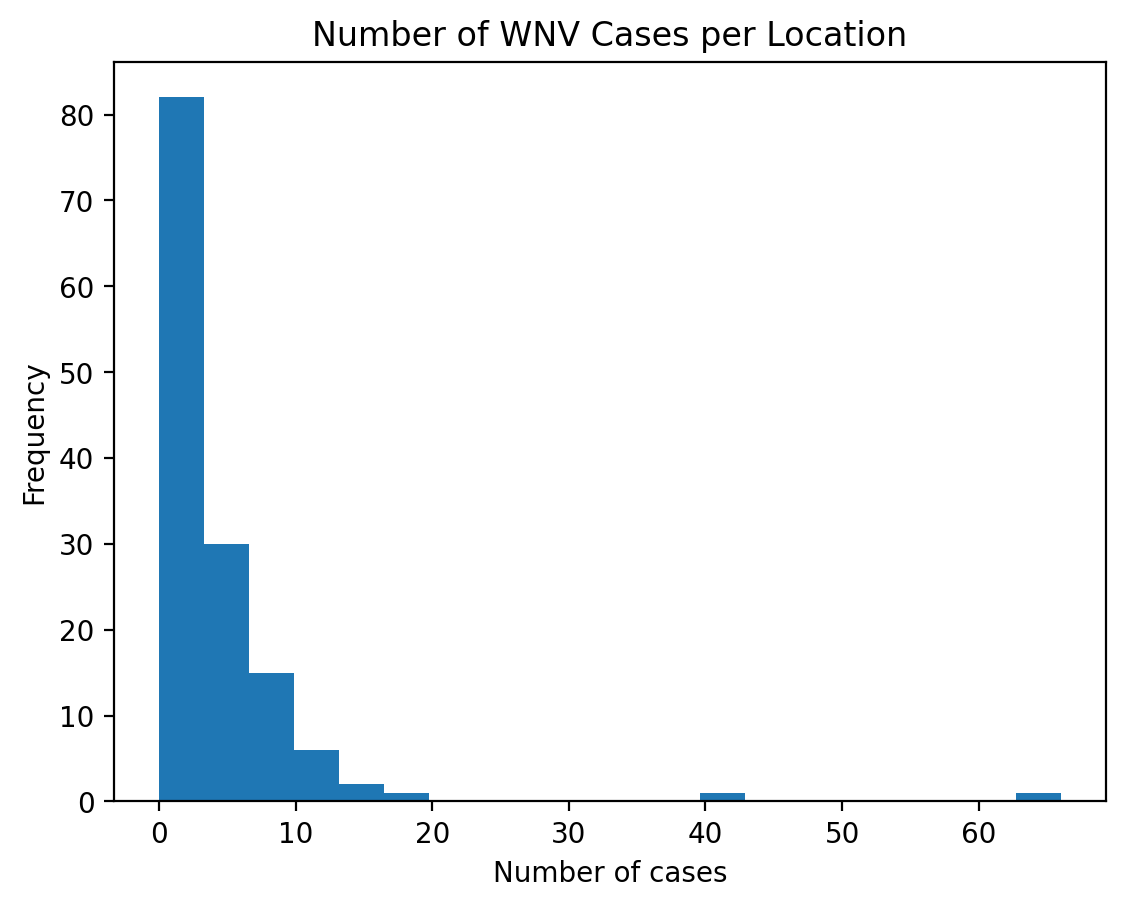

        Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame containing the data
# Create a pivot table to sum the number of WNV cases detected at each location
wnv_risk = train.groupby('Address').agg({'WnvPresent': 'sum'}).reset_index()

# Display statistics of WNV cases detected
print(wnv_risk.describe().round()) 

# Plot histogram to show the spread in the number of WNV cases detected
plt.title("Number of WNV Cases per Location")
plt.ylabel("Frequency")
plt.xlabel("Number of cases")
plt.hist(wnv_risk['WnvPresent'], bins=20)
plt.show()

# Define bins and labels - Risk Assesment 0 cases, very low, 2 - low, 6 - medium, 10 - high
bins = [0, 2, 6, 10, float('inf')]
labels = ['very low', 'low', 'medium', 'high']

# Create the WNV_risk feature
wnv_risk['WNV_risk'] = pd.cut(wnv_risk['WnvPresent'], bins=bins, right=False, labels=labels, ordered=True)


# Merge risk data with train data, dummify the categorical variable, and drop original
train = train.merge(wnv_risk[['Address', 'WNV_risk']], how='left', on='Address')
train = pd.get_dummies(train, columns=['WNV_risk'], prefix='WnvRisk')

print(train.head())


<div style="color:red;">????<div> 
In order to reduce the complexity and choose the most important features, we used general knowledge and domain knowledge.

#### Train and Test Data

**Features to Keep:**
- **`Date`**: Temporal patterns can influence mosquito activity and WNV presence. [2]
- **`Species`**: Different mosquito species have varying propensities to carry WNV. [3]
- **`Address`**: Geographic location is critical for spatial analysis of virus presence. Using address instead of coordinates allows us to categorize coordinates and assign them with a risk level (see code above).
- **`Trap`**: Specific traps might have consistent results based on their locations.
- **`NumMosquitos`**: Higher mosquito counts might correlate with a higher likelihood of virus presence.

**Features to Drop:**
- ~~**`Block`**~~: Redundant when using Latitude and Longitude.
- ~~**`Street`**~~: Not useful for modeling; geographical coordinates are more precise.
- ~~**`AddressNumberAndStreet`**~~: Redundant when using Address.
- ~~**`AddressAccuracy`**~~: Provided geocoded data already has adequate accuracy.
- ~~**`Latitude`**, **`Longitude`**~~: Already using Address.

#### Weather Data

"Mosquito seasonal activity is largely driven by weather conditions, most notably temperature, precipitation, and relative humidity." [5]

**Features to Keep:**
- **`Station`**: Different weather stations can provide location-specific weather data.
- **`Date`**: Temporal patterns can influence mosquito activity and WNV presence. [2]
- **`Tmax`**, **`Tmin`**, **`Tavg`**: Temperature extremes and averages can influence mosquito behavior. [2]
- **`DewPoint`**: Indicator of moisture in the air, which can affect mosquito breeding.
- **`PrecipTotal`**: Total precipitation; standing water is critical for mosquito breeding.
- **`StnPressure`**, **`SeaLevel`**: Atmospheric pressure might influence mosquito activity.

**Features to Drop:**
- ~~**`Depart`**~~: Departure from average might not be as useful as absolute values.
- ~~**`WetBulb`**~~: Similar information provided by DewPoint.
- ~~**`Heat`**, **`Cool`**~~: Redundant when using temperature data.
- ~~**`Sunrise`**, **`Sunset`**~~: Not directly relevant to mosquito activity.
- ~~**`CodeSum`**~~: Categorical weather codes that might be complex to integrate.
- ~~**`SnowFall`**~~: Mosquitoes only exist in dormancy during winter (or when it snows) and do not breed or thrive in any capacity. [6]
- ~~**`Water1`**~~: Only has missing values.
- ~~**`ResultSpeed`**, **`ResultDir`**, **`AvgSpeed`**~~: Wind speed and direction are not nearly as relevant as temperature, precipitation, and relative humidity.

#### Spray Data

**Features to Keep:**
- **`Date`**: Temporal alignment with mosquito data.
- **`Time`**: Time of day might influence effectiveness.
- **`Latitude`**, **`Longitude`**: Location of spraying is crucial for understanding its impact.

## References

[1] https://www.mdpi.com/2225-1154/7/9/101#:~:text=In%20climate%20science%2C%20climate%20departure,27%2C28%2C29%5D.

[2] https://eu.usatoday.com/story/news/2023/05/29/how-long-do-mosquitoes-live/70228628007/

[3] https://www.epa.gov/sites/default/files/2021-01/documents/wetlands_west_nile_virus.pdf

[4] https://www.wearegreenbay.com/weather/beyondtheforecast/what-weather-conditions-lead-to-mosquitos-being-more-active/#:~:text=Temperatures%20can%20get%20too%20hot,the%20cooler%20temperatures%20of%20winter.

[5] https://parasitesandvectors.biomedcentral.com/articles/10.1186/s13071-023-05760-x

[6] https://www.vdci.net/blog/where-do-mosquitoes-go-in-the-winter/#:~:text=By%20entering%20a%20state%20of,areas%20with%20significant%20seasonal%20variation.

In [138]:
weather.drop(["Depart", "WetBulb", "Heat", "Cool", "Sunrise", "Sunset", "Depth",
              "Water1", "SnowFall", "ResultSpeed", "ResultDir"], axis=1, inplace=True)

weather.head()



,Station,Date,Tmax,Tmin,Tavg,DewPoint,CodeSum,PrecipTotal,StnPressure,SeaLevel,AvgSpeed,Year,Month,Day,Year Month
0,1,2007-05-01,83,50,67,51,,0.00,29.10,29.82,9.2,2007,5,1,2007 05
1,2,2007-05-01,84,52,68,51,,0.00,29.18,29.82,9.6,2007,5,1,2007 05
2,1,2007-05-02,59,42,51,42,BR,0.00,29.38,30.09,13.4,2007,5,2,2007 05
3,2,2007-05-02,60,43,52,42,BR HZ,0.00,29.44,30.08,13.4,2007,5,2,2007 05
4,1,2007-05-03,66,46,56,40,,0.00,29.39,30.12,11.9,2007,5,3,2007 05


### 4.2 Data Cleaning Based on Steps Outlined in [Slides for Data Preparation](/Vorlesungen/2024_08_Data%20Preparation.pdf) 

### Before

#### Data Cleansing

In [139]:


display(Markdown("### Train DataFrame - Before"))
display(train.head())

display(Markdown("### Test DataFrame - Before"))
display(test.head())

display(Markdown("### Weather DataFrame - Before"))
display(weather.head())

display(Markdown("### Spray DataFrame - Before"))
display(spray.head())

### Train DataFrame - Before

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,WnvRisk_very low,WnvRisk_low,WnvRisk_medium,WnvRisk_high
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,False,False,False,True
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,False,False,False,True
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,True,False,False,False
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,False,True,False,False
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,False,True,False,False


### Test DataFrame - Before

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


### Weather DataFrame - Before

,Station,Date,Tmax,Tmin,Tavg,DewPoint,CodeSum,PrecipTotal,StnPressure,SeaLevel,AvgSpeed,Year,Month,Day,Year Month
0,1,2007-05-01,83,50,67,51,,0.00,29.10,29.82,9.2,2007,5,1,2007 05
1,2,2007-05-01,84,52,68,51,,0.00,29.18,29.82,9.6,2007,5,1,2007 05
2,1,2007-05-02,59,42,51,42,BR,0.00,29.38,30.09,13.4,2007,5,2,2007 05
3,2,2007-05-02,60,43,52,42,BR HZ,0.00,29.44,30.08,13.4,2007,5,2,2007 05
4,1,2007-05-03,66,46,56,40,,0.00,29.39,30.12,11.9,2007,5,3,2007 05


### Spray DataFrame - Before

,Date,Time,Latitude,Longitude,Year,Month,Day,Year Month
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011,8,29,2011 08
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011,8,29,2011 08
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011,8,29,2011 08
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011,8,29,2011 08
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011,8,29,2011 08


In [140]:
text_columns = ['Address', 'Species', 'Street', 'AddressNumberAndStreet']


##### Turn all characters into capital letters to level case sensitivity

In [141]:


def level_case_sensitivity(df, columns):
    for column in columns:
        df[column] = df[column].str.upper()
        df[column] = df[column].str.strip()
    return df

train = level_case_sensitivity(train, text_columns)
test = level_case_sensitivity(test, text_columns)




##### Remove spaces and non-printing characters (\n, \t etc.)

In [142]:

def rm_spaces_nonprinting_chars(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x: re.sub(r'[\n\t]', '', x) if isinstance(x, str) else x)
        # df[column] = df[column].apply(lambda x: replace_abbreviations(x, abbreviations) if isinstance(x, str) else x)
    return df
train = rm_spaces_nonprinting_chars(train, text_columns)
test = rm_spaces_nonprinting_chars(test, text_columns)



##### Replace abbreviations by their long form (dictionary)

In [143]:
# Unnecessary, if we use the Adress Column

##### Fix the format of numbers, data, and time (decimal point! Datetime objects or standard date format, i.e. YYYY-MM-DD)

##### Split fields that carry mixed information into separate ones (“Chocolate, 100g” → “Chocolate” and “100.0”)

In [144]:
for df in [train, test]:
    # drop multiple columns containing address information as they are duplicated info within the dataframe
    df.drop(["Address", "Block", "Street", "AddressAccuracy"], axis=1, inplace=True)
    # Removing substring chicago, illinois as this remains the same for all addresses
    df['AddressNumberAndStreet'] = df['AddressNumberAndStreet'].str.replace(', CHICAGO, IL', '')
    





##### Use spell-checker or stemming to normalize spelling

In [145]:
# In our case this is not necessary, since he text fields are already cleaned (Address/ Species, etc.)


##### Normalize the writing of addresses and names, possibly ignoring the order of title, surname, forename, etc. to ease their re-identification

##### EXTRA: Validate that the Adresses are correct

In [146]:
# In our case, we don't have any names, and we've already normalized

##### Convert numerical values into standard units, especially if data from different sources and different countries are used

In [147]:
# Conversion functions
def fahrenheit_to_celsius(f):
    return round((f - 32) * 5.0/9.0, 2)

def inhg_to_mbar(inhg):
    return round(inhg * 33.8639, 2)

def mph_to_kmph(mph):
    return round(mph * 1.60934, 2)

# Convert relevant columns to numeric type if they are not already
numeric_columns = ['Tmax', 'Tmin', 'Tavg', 'StnPressure', 'SeaLevel', 'AvgSpeed']
weather[numeric_columns] = weather[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Applying conversions to the DataFrame
weather['Tmax'] = weather['Tmax'].apply(fahrenheit_to_celsius)
weather['Tmin'] = weather['Tmin'].apply(fahrenheit_to_celsius)
weather['Tavg'] = weather['Tavg'].apply(fahrenheit_to_celsius)
weather['StnPressure'] = weather['StnPressure'].apply(inhg_to_mbar)
weather['SeaLevel'] = weather['SeaLevel'].apply(inhg_to_mbar)
weather['AvgSpeed'] = weather['AvgSpeed'].apply(mph_to_kmph)

# Print updated dataframe to check changes
print(weather.head())

   Station       Date   Tmax   Tmin   Tavg  DewPoint CodeSum PrecipTotal  \
0        1 2007-05-01  28.33  10.00  19.44        51                0.00   
1        2 2007-05-01  28.89  11.11  20.00        51                0.00   
2        1 2007-05-02  15.00   5.56  10.56        42      BR        0.00   
3        2 2007-05-02  15.56   6.11  11.11        42   BR HZ        0.00   
4        1 2007-05-03  18.89   7.78  13.33        40                0.00   

   StnPressure  SeaLevel  AvgSpeed  Year  Month  Day Year Month  
0       985.44   1009.82     14.81  2007      5    1    2007 05  
1       988.15   1009.82     15.45  2007      5    1    2007 05  
2       994.92   1018.96     21.57  2007      5    2    2007 05  
3       996.95   1018.63     21.57  2007      5    2    2007 05  
4       995.26   1019.98     19.15  2007      5    3    2007 05  



##### Use dictionaries containing all possible values of an attribute to assure that all values comply with the domain knowledge

In [148]:
import os
import json
import pandas as pd

def write_unique_values_to_json(dataframes, output_directory):
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Function to handle non-serializable data types
    def default_converter(o):
        if isinstance(o, pd.Timestamp):
            return o.isoformat()
        raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")
    
    # Iterate over each dataframe
    for df in dataframes:
        # Ensure the dataframe has a name attribute
        if not hasattr(df, 'name'):
            raise AttributeError("DataFrame is missing a 'name' attribute")
        
        # Create a dictionary to store unique values for each column
        unique_values_dict = {}
        
        # Iterate over each column in the dataframe
        for column in df.columns:
            # Get unique values and convert them to a list
            unique_values = df[column].dropna().unique().tolist()
            # Convert any non-serializable items
            unique_values = [x if isinstance(x, (int, float, str)) else default_converter(x) for x in unique_values]
            # Store unique values in the dictionary
            unique_values_dict[column] = unique_values
        
        # Construct the output file path
        output_file = os.path.join(output_directory, f'{df.name}_unique_values.json')
        
        # Write the unique values dictionary to a JSON file
        with open(output_file, 'w') as f:
            json.dump(unique_values_dict, f, indent=4)
        
        print(f'Unique values for {df.name} written to {output_file}')

# Example usage
train.name = 'train'
test.name = 'test'
weather.name = 'weather'
spray.name = 'spray'

# Specify output directory
output_directory = '../data/unique_values_output'

# Call the function with the list of DataFrames
write_unique_values_to_json([train, test, weather, spray], output_directory)


Unique values for train written to ../data/unique_values_output/train_unique_values.json
Unique values for test written to ../data/unique_values_output/test_unique_values.json
Unique values for weather written to ../data/unique_values_output/weather_unique_values.json
Unique values for spray written to ../data/unique_values_output/spray_unique_values.json


#### Missing Values


In [149]:
import pandas as pd
from IPython.display import display, Markdown

# Predefined list of missing value indicators
missing_values = ['', 'M', '-']
low_values=['T', ' T', '  T']
def analyze_dataframe(df, name):
    # Displaying the name of the DataFrame
    display(Markdown(f"### {name} DataFrame Analysis"))

    # Displaying the number of missing values calculated by isnull()
    null_values = df.isnull().sum()
    if null_values.any():
        display(null_values[null_values > 0])
        display(Markdown("\n**Missing Values in Each Column (Detected by `isnull()`):**"))
    else:
        display(Markdown("\n**No Missing Values Detected by `isnull()`**"))

    # Displaying the number of duplicate rows in the DataFrame
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        display(Markdown("\n**Number of Duplicate Rows:**"))
        display(duplicate_count)
    else:
        display("No duplicate rows found in the DataFrame.")
    # Looping through each custom missing value indicator to display counts
    for value in missing_values:
        specific_value_count = df.isin([value]).sum()
        if specific_value_count.any():
            display(Markdown(f"\n**Count of '{value}' Values in Each Column:**"))
            display(specific_value_count[specific_value_count > 0].sort_values(ascending=False))
    
    # Calculating total missing data including custom missing values without replacing DataFrame

    total_missing_per_column = df.isnull().sum()  # start with null values
    for value in missing_values:
        total_missing_per_column += df.isin([value]).sum()

    # Calculating the percentage of total missing data for each column
    total_entries = len(df)
    missing_percentage = (total_missing_per_column / total_entries * 100).round(2)
    
    # Displaying the percentage of missing data
    missing_info = missing_percentage[missing_percentage > 0].astype(str) + '% (' + total_missing_per_column[total_missing_per_column > 0].astype(str) + '/' + str(total_entries) + ')'
    if(missing_info.any()):
        display(Markdown("\n**Detailed Missing Values Analysis**"))
        display(Markdown("\n**Percentage of Total Missing Data in Each Column:**"))
        display(missing_info)
    else:
        display(Markdown("\n**No Missing Values Detected**"))


analyze_dataframe(weather, "WEATHER")
analyze_dataframe(train, "TRAIN")
analyze_dataframe(test, "TEST")
analyze_dataframe(spray, "SPRAY")

### WEATHER DataFrame Analysis

Tavg           11
StnPressure     4
SeaLevel        9
AvgSpeed        3
dtype: int64


**Missing Values in Each Column (Detected by `isnull()`):**

'No duplicate rows found in the DataFrame.'


**Count of 'M' Values in Each Column:**

PrecipTotal    2
dtype: int64


**Detailed Missing Values Analysis**


**Percentage of Total Missing Data in Each Column:**

Tavg           0.37% (11/2944)
PrecipTotal     0.07% (2/2944)
StnPressure     0.14% (4/2944)
SeaLevel        0.31% (9/2944)
AvgSpeed         0.1% (3/2944)
dtype: object

### TRAIN DataFrame Analysis


**No Missing Values Detected by `isnull()`**


**Number of Duplicate Rows:**

813


**No Missing Values Detected**

### TEST DataFrame Analysis


**No Missing Values Detected by `isnull()`**

'No duplicate rows found in the DataFrame.'


**No Missing Values Detected**

### SPRAY DataFrame Analysis

Time    584
dtype: int64


**Missing Values in Each Column (Detected by `isnull()`):**


**Number of Duplicate Rows:**

541


**Detailed Missing Values Analysis**


**Percentage of Total Missing Data in Each Column:**

Time    3.94% (584/14835)
dtype: object

In [ ]:

# Function to replace custom missing values with None
def standardize_missing_values(df, missing_values):
    return df.replace(missing_values, np.nan, inplace=True)



for df in [train, test, weather, spray]:
    df = standardize_missing_values(df, missing_values)





##### Spray

In [ ]:
# Spray has duplicate Rows, which we will remove
spray.drop_duplicates(keep="first", inplace=True, ignore_index=True)

# Spray also has missing entries for Time, which simply can't be imputed, so we will drop these rows
spray.drop(["Time"], axis=1, inplace=True)

analyze_dataframe(spray, "SPRAY")




### SPRAY DataFrame Analysis


**No Missing Values Detected by `isnull()`**

'No duplicate rows found in the DataFrame.'


**No Missing Values Detected**



##### Weather


In [ ]:

# Tavg can easily be imputed by averaging Tmax and Tmin

weather['Tavg'] = (weather['Tmax'] + weather['Tmin']) / 2

# Insignificant Precipitation is marked as 'T'. We will replace it with 0
weather['PrecipTotal'].replace(low_values, 0, inplace=True)

# PrecipTotal only has 2 missing values, so we can fill them in

weather['PrecipTotal'] = weather['PrecipTotal'].fillna(method='ffill')

# The other missing features are StnPressure, AvgSpeed and SeaLevel. We will fill them with the median value
weather["StnPressure"].fillna(weather["StnPressure"].median(), inplace=True)
weather["SeaLevel"].fillna(weather["SeaLevel"].median(), inplace=True)
weather["AvgSpeed"].fillna(weather["AvgSpeed"].median(), inplace=True)
# Furthermore, we want to convert numerical features to a niumvber

weather["StnPressure"] = weather["StnPressure"].astype(float)
weather["SeaLevel"] = weather["SeaLevel"].astype(float)
weather["PrecipTotal"] = weather["PrecipTotal"].astype(float)



analyze_dataframe(weather, "WEATHER")
weather[weather["PrecipTotal"].isna()]
# TDO: PrecipTotal
analyze_dataframe(weather, "WEATHER")




/var/folders/sc/8x239hs11msdtbv2t7y2n7b00000gn/T/ipykernel_13670/3187073219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather['PrecipTotal'] = weather['PrecipTotal'].fillna(method='ffill')


### WEATHER DataFrame Analysis


**No Missing Values Detected by `isnull()`**

'No duplicate rows found in the DataFrame.'


**No Missing Values Detected**

### WEATHER DataFrame Analysis


**No Missing Values Detected by `isnull()`**

'No duplicate rows found in the DataFrame.'


**No Missing Values Detected**


###### Feature - Relative humidity (Important, as Mosquittos tend to increase their size alongside hiher relative Humidity Levels)
Source: https://www.calcunation.com/calculator/humidity-calculator.php
This was only possible, once all missing values were removed, hence its positioning

In [ ]:

import pandas as pd
import numpy as np

# Calculate Relative Humidity
weather['RelativeHumidity'] = 100 * (np.exp((17.67 * ((weather['DewPoint'] - 32) * (5/9))) / 
                                           (243.5 + ((weather['DewPoint'] - 32) * (5/9)))) 
                                    /
                                    np.exp((17.67 * ((weather['Tavg'] - 32) * (5/9))) /
                                           (243.5 + ((weather['Tavg'] - 32) * (5/9))))
                                    )
weather['RelativeHumidity'] = weather['RelativeHumidity'].apply(fahrenheit_to_celsius)



##### TRAIN

In [ ]:
# TRAIN has duplicate Rows, which we will remove
train.drop_duplicates(keep="first", inplace=True, ignore_index=True)

analyze_dataframe(train, "TRAIN")

### TRAIN DataFrame Analysis


**No Missing Values Detected by `isnull()`**

'No duplicate rows found in the DataFrame.'


**No Missing Values Detected**

- **Turn the considered attribute 𝑋 into a binary attribute, replacing all measured values by “yes” and all missing values by “no”**
- **Build a classifier with the now binary attribute 𝑋 as the target attribute, and use all other attributes for the prediction of the class values “yes” and “no”**
- **Determine the misclassification rate, which is the proportion of data objects that are not assigned to the correct class by the classifier.**

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import LabelEncoder

# def calculate_misclassification_rate(dataframe, column):
#     # Convert the specified column into a binary attribute
#     dataframe[column + "_binary"] = dataframe[column].apply(lambda x: 'yes' if pd.notna(x) else 'no')
    
#     # Drop the original column and binary column from the feature set
#     X = dataframe.drop(columns=[column, column + "_binary"])
#     y = dataframe[column + "_binary"]
    
#     # Encode categorical variables
#     for col in X.columns:
#         if X[col].dtype == 'object':
#             le = LabelEncoder()
#             X[col] = le.fit_transform(X[col].astype(str))
    
#     # Split the data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     # Initialize and train the classifier
#     classifier = DecisionTreeClassifier(random_state=42)
#     classifier.fit(X_train, y_train)
    
#     # Make predictions
#     y_pred = classifier.predict(X_test)
    
#     # Determine the misclassification rate
#     accuracy = accuracy_score(y_test, y_pred)
#     misclassification_rate = 1 - accuracy
    
#     return misclassification_rate

# # Example usage
# # Note: Replace `dataframe_name` with the actual dataframe variable names in your code
# # print(calculate_misclassification_rate(spray, 'Time'))
# # print(calculate_misclassification_rate(train, 'ZIP'))
# # print(calculate_misclassification_rate(test, 'ZIP'))
# # print(calculate_misclassification_rate(weather, 'SnowFall'))
# # print(calculate_misclassification_rate(weather, 'Depth'))
# # print(calculate_misclassification_rate(weather, 'Depart'))


##### Outlier Detection

In [ ]:

BBox_spray = ((spray.Longitude.min(), spray.Longitude.max(),
        spray.Latitude.min(), spray.Latitude.max()))

BBox_spray

(-88.0964683333333, -87.5867266666667, 41.713925, 42.3959833333333)

###### Univariate Outlier Detection

In [ ]:
# check date range of our data
 
for df in [train, test]:
  print("Earliest Record: ", train.Date.min())
  print("Latest Record: ", train.Date.max())

Earliest Record:  2007-05-29 00:00:00
Latest Record:  2013-09-26 00:00:00
Earliest Record:  2007-05-29 00:00:00
Latest Record:  2013-09-26 00:00:00


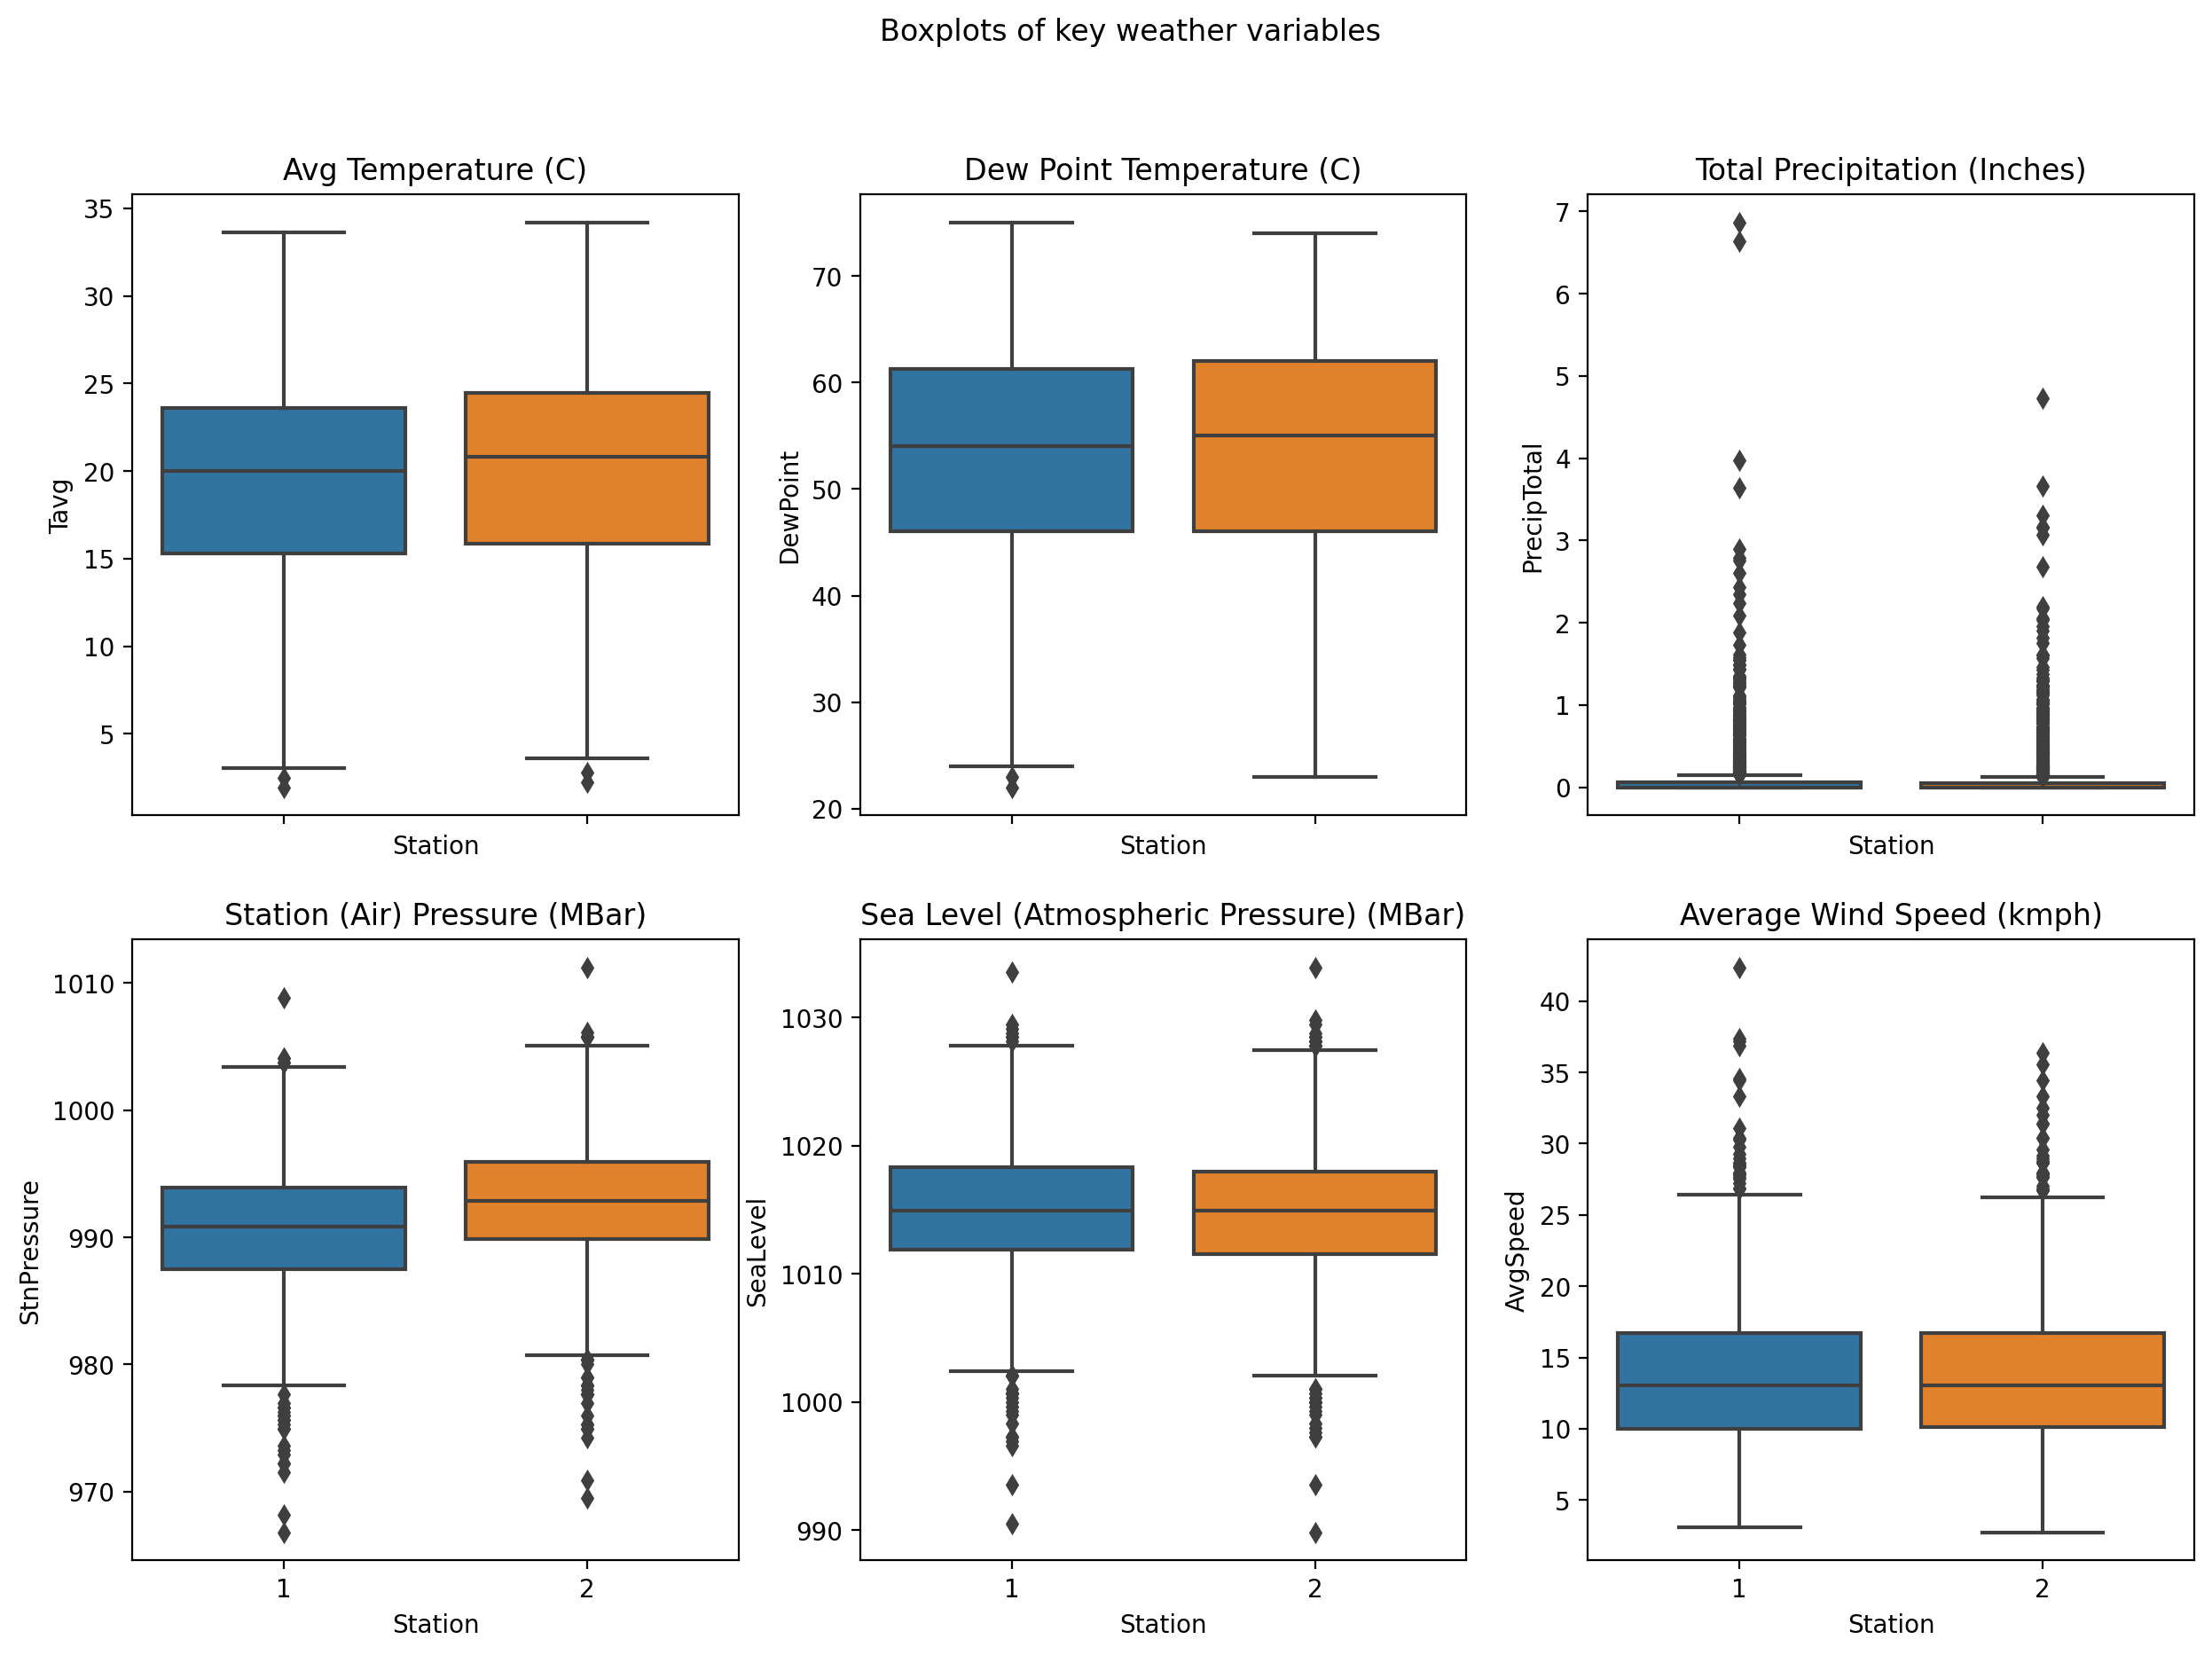

In [ ]:


fig, axes = plt.subplots(2, 3, sharex=True, figsize=(15,10))
fig.suptitle('Boxplots of key weather variables')

axes[0,0].set_title('Avg Temperature (C)')
sns.boxplot(y="Tavg", x="Station", data=weather, ax=axes[0,0])

axes[0,1].set_title('Dew Point Temperature (C)')
sns.boxplot(y="DewPoint", x="Station", data=weather, ax=axes[0,1])

axes[0,2].set_title('Total Precipitation (Inches)')
sns.boxplot(y="PrecipTotal", x="Station", data=weather, ax=axes[0,2])

axes[1,0].set_title('Station (Air) Pressure (MBar)')
sns.boxplot(y="StnPressure", x="Station", data=weather, ax=axes[1,0])

axes[1,1].set_title('Sea Level (Atmospheric Pressure) (MBar)')
sns.boxplot(y="SeaLevel", x="Station", data=weather, ax=axes[1,1])

axes[1,2].set_title('Average Wind Speed (kmph)')
sns.boxplot(y="AvgSpeed", x="Station", data=weather, ax=axes[1,2]);





###### Multivariate Outlier Detection

In [ ]:


# # Scatter plots for pairs of numerical attributes
# sns.pairplot(train[numerical_cols])
# plt.show()

# # PCA for visualizing in 2D
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(train[numerical_cols])

# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(scaled_data)

# plt.figure(figsize=(10, 5))
# plt.scatter(pca_result[:, 0], pca_result[:, 1])
# plt.title('PCA of numerical attributes')
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')
# plt.show()

# # DBSCAN for clustering
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# clusters = dbscan.fit_predict(scaled_data)

# plt.figure(figsize=(10, 5))
# plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters)
# plt.title('DBSCAN Clustering of numerical attributes')
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')
# plt.show()


### 4.3 Data Transformation and Integration

In [ ]:
# The weather conditions are encoded in the CodeSum column. We weill use Rainy, Snowy, Windy, Hazy as Umbrella Terms for various Conditions
weather["CodeSum"].unique()

# List of valid weather codes
codes = ['+FC','FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL',
         'IC', 'FG+', 'FG', 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS',
         'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 'SH', 'FZ', 'MI', 'PR',
         'BC', 'BL', 'VC']

# Function to clean and filter codes in CodeSum
def clean_codes(code_string):
    filtered_codes = [code for code in code_string.split() if code in codes]
    return ' '.join(filtered_codes)

# Apply the function to the CodeSum column
weather['CodeSum'] = weather['CodeSum'].apply(clean_codes)

# Define a dictionary for conditions and their corresponding weather codes
conditions = {
    "Rainy": ['TS', 'RA', 'DZ', 'SH'],
    "Snowy": ['SN', 'SG', 'GS', 'PL', 'IC', 'DR', 'BC', 'GR'],
    "Windy": ['SQ', 'DS', 'SS', 'PO', 'BL'],
    "Hazy": ['BR', 'HZ', 'FG', 'FU']
}

# Function to create dummy variables based on conditions
def mark_conditions(row, condition_codes):
    return any(code in row['CodeSum'].split() for code in condition_codes)

# Apply the function to create dummy columns for each condition
for condition, codes in conditions.items():
    weather[condition] = weather.apply(mark_conditions, condition_codes=codes, axis=1).astype(int)
weather.drop(["CodeSum"], axis=1, inplace=True)

# Display the last entries in the dataframe
weather.tail()



,Station,Date,Tmax,Tmin,Tavg,DewPoint,PrecipTotal,StnPressure,SeaLevel,AvgSpeed,Year,Month,Day,Year Month,RelativeHumidity,Rainy,Snowy,Windy,Hazy
2939,2,2014-10-29,9.44,4.44,6.940,34,0.00,996.28,1018.29,14.48,2014,10,29,2014 10,158.00,0,0,0,0
2940,1,2014-10-30,10.56,0.00,5.280,34,0.00,993.57,1018.96,8.85,2014,10,30,2014 10,171.80,0,0,0,0
2941,2,2014-10-30,11.67,2.78,7.225,35,0.00,995.94,1019.30,10.46,2014,10,30,2014 10,162.80,1,0,0,0
2942,1,2014-10-31,8.33,0.56,4.445,25,0.03,998.65,1022.69,36.85,2014,10,31,2014 10,118.68,1,1,0,0
2943,2,2014-10-31,9.44,1.11,5.275,29,0.04,1000.34,1022.69,36.37,2014,10,31,2014 10,137.15,1,1,0,1


In [ ]:
# To differentiate between Mosquitto species, we will create a dummy variable for each species
import pandas as pd

# Assuming 'train' is your DataFrame and 'Species' is the column to check

# Example DataFrame
# train = pd.DataFrame({'Species': ['PIPIENS', 'RESTUANS', 'PIPIENS RESTUANS', 'OTHER']})

species = ["PIPIENS", "RESTUANS"]

# Initialize columns with zeros
for sp in species:
    train[sp] = 0

# Use vectorized string operations to check for presence of species
for sp in species:
    train[sp] = train['Species'].str.contains(sp).astype(int)

# Display the DataFrame to check the result
print(train)

train.drop("Species", axis=1, inplace=True)
train.head()

           Date                 Species  Trap AddressNumberAndStreet  \
0    2007-05-29  CULEX PIPIENS/RESTUANS  T002   4100  N OAK PARK AVE   
1    2007-05-29          CULEX RESTUANS  T002   4100  N OAK PARK AVE   
2    2007-05-29          CULEX RESTUANS  T007    6200  N MANDELL AVE   
3    2007-05-29  CULEX PIPIENS/RESTUANS  T015     7900  W FOSTER AVE   
4    2007-05-29          CULEX RESTUANS  T015     7900  W FOSTER AVE   
...         ...                     ...   ...                    ...   
9688 2013-09-26  CULEX PIPIENS/RESTUANS  T035        5100  W 72ND ST   
9689 2013-09-26  CULEX PIPIENS/RESTUANS  T231      5800  N RIDGE AVE   
9690 2013-09-26  CULEX PIPIENS/RESTUANS  T232    1700  N ASHLAND AVE   
9691 2013-09-26  CULEX PIPIENS/RESTUANS  T233     7100  N HARLEM AVE   
9692 2013-09-26  CULEX PIPIENS/RESTUANS  T235        4200  W 65TH ST   

       Latitude  Longitude  NumMosquitos  WnvPresent  WnvRisk_very low  \
0     41.954690 -87.800991             1           0         

,Date,Trap,AddressNumberAndStreet,Latitude,Longitude,NumMosquitos,WnvPresent,WnvRisk_very low,WnvRisk_low,WnvRisk_medium,WnvRisk_high,PIPIENS,RESTUANS
0,2007-05-29,T002,4100 N OAK PARK AVE,41.954690,-87.800991,1,0,False,False,False,True,1,1
1,2007-05-29,T002,4100 N OAK PARK AVE,41.954690,-87.800991,1,0,False,False,False,True,0,1
2,2007-05-29,T007,6200 N MANDELL AVE,41.994991,-87.769279,1,0,True,False,False,False,0,1
3,2007-05-29,T015,7900 W FOSTER AVE,41.974089,-87.824812,1,0,False,True,False,False,1,1
4,2007-05-29,T015,7900 W FOSTER AVE,41.974089,-87.824812,4,0,False,True,False,False,0,1


In [ ]:
###### Data Integration - Merging Train and Weather Data

In [ ]:
from geopy.distance import geodesic

def assign_station_v2(lat, lng):
    station1_coordinates  = (41.995, -87.933)
    station2_coordinates  = (41.786, -87.752)
    coord_curr = (lat, lng)
    distance_to_stn1 = geodesic(coord_curr, station1_coordinates ).miles
    distance_to_stn2 = geodesic(coord_curr, station2_coordinates ).miles
    return 1 if distance_to_stn1 < distance_to_stn2 else 2

train['Station'] = train.apply(lambda row: assign_station_v2(row['Latitude'], row['Longitude']), axis=1)

station_distribution = train['Station'].value_counts(normalize=True)
print(station_distribution)

train = train.merge(weather, how='left', on=['Station', 'Date'])
train.head()


Station
2    0.679356
1    0.320644
Name: proportion, dtype: float64


,Date,Trap,AddressNumberAndStreet,Latitude,Longitude,NumMosquitos,WnvPresent,WnvRisk_very low,WnvRisk_low,WnvRisk_medium,...,AvgSpeed,Year,Month,Day,Year Month,RelativeHumidity,Rainy,Snowy,Windy,Hazy
0,2007-05-29,T002,4100 N OAK PARK AVE,41.954690,-87.800991,1,0,False,False,False,...,10.46,2007,5,29,2007 05,195.64,0,0,0,1
1,2007-05-29,T002,4100 N OAK PARK AVE,41.954690,-87.800991,1,0,False,False,False,...,10.46,2007,5,29,2007 05,195.64,0,0,0,1
2,2007-05-29,T007,6200 N MANDELL AVE,41.994991,-87.769279,1,0,True,False,False,...,10.46,2007,5,29,2007 05,195.64,0,0,0,1
3,2007-05-29,T015,7900 W FOSTER AVE,41.974089,-87.824812,1,0,False,True,False,...,10.46,2007,5,29,2007 05,195.64,0,0,0,1
4,2007-05-29,T015,7900 W FOSTER AVE,41.974089,-87.824812,4,0,False,True,False,...,10.46,2007,5,29,2007 05,195.64,0,0,0,1


/Users/nilst/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


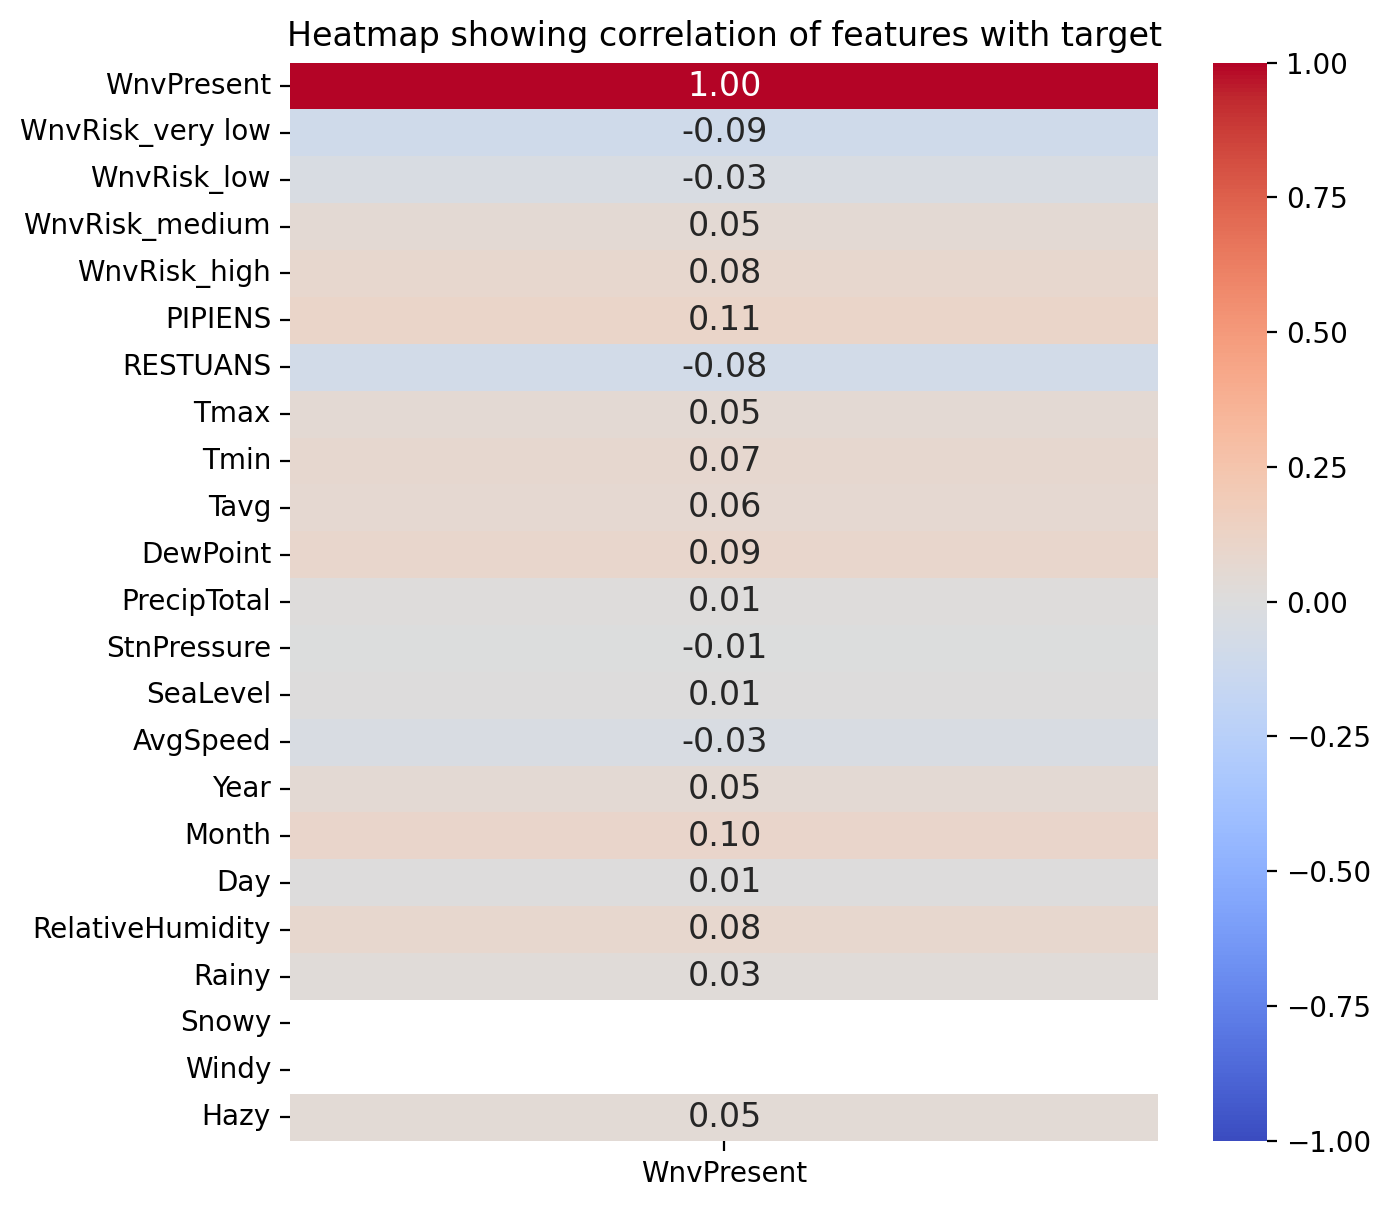

In [ ]:
# create a temporary dataframe and drop categorical data and variables that are not present in test set
df_temp = train.drop(["Date", "Station", "AddressNumberAndStreet", "Latitude", "Longitude", 
                              "NumMosquitos", "Trap", 'Year Month'], axis=1)

plt.figure(figsize=(7,7))
plt.title("Heatmap showing correlation of features with target")
sns.heatmap(df_temp.corr()[["WnvPresent"]], annot=True, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

In [ ]:
train.drop([ "AddressNumberAndStreet", "Latitude", "Longitude", 
                              "NumMosquitos", "Year", "Trap"], axis=1, inplace=True)
# create a function to transform the weather features to incorporate the lagging effects
weather['Year Month'] = weather['Date'].dt.strftime('%Y %m')

def add_weather_stats(df: pd.DataFrame) -> pd.DataFrame:
    # Adding Year Month columns to aggregrate weather data by year and month
    weather['Year_Month'] = weather['Date'].dt.strftime('%Y %m')
    
    # Adding this to use as key for lag variables
    df['Year Month L1'] = df['Date'] - pd.DateOffset(months=1)
    df['Year Month L1'] = df['Year Month L1'].dt.strftime('%Y %m')

    # Creating a temporary pivot table to extract weather states by year month
    pivot = pd.DataFrame(pd.pivot_table(data=weather, index=['Station','Year_Month'], 
                                        values=['Tmin', 'Tmax', 'DewPoint', 'PrecipTotal', 'SeaLevel', 
                                                'AvgSpeed', 'RelativeHumidity'], aggfunc='mean').to_records())
    
    # Rename the columns in the pivot table
    old_col = pivot.drop('Station', axis='columns').columns
    new_col = old_col + "_"
    pivot = pivot.rename(columns = dict(zip(old_col.tolist(), new_col.tolist())))
    
    # Assigning aggregated year month values into train from pivot
    for item in new_col[1:]:
        df = pivot[['Station', 'Year_Month_', item]].merge(df, 
                                                           how='right', left_on=['Station', 'Year_Month_'], 
                                                           right_on=['Station', 'Year Month'])  \
                                                                     .rename(columns={item: item + 'L0'})  \
                                                                     .drop(['Year_Month_'], axis='columns')
        
        df = pivot[['Station', 'Year_Month_', item]].merge(df, how='right', 
                                                           left_on=['Station', 'Year_Month_'], 
                                                           right_on=['Station', 'Year Month L1'])  \
                                                                     .rename(columns={item: item + 'L1'})  \
                                                                     .drop(['Year_Month_'], axis='columns')
    
    return df
  
train = add_weather_stats(train)
train = train[(train['Year Month'] != '2007 05') & (train['Year Month'] != '2009 05')]
train = train.drop(['Year Month', 'Year Month L1', 'Station', 'Date'], axis='columns')
train.info()



<class 'pandas.core.frame.DataFrame'>
Index: 9610 entries, 25 to 9692
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Tmin_L1              9610 non-null   float64
 1   Tmin_L0              9610 non-null   float64
 2   Tmax_L1              9610 non-null   float64
 3   Tmax_L0              9610 non-null   float64
 4   SeaLevel_L1          9610 non-null   float64
 5   SeaLevel_L0          9610 non-null   float64
 6   RelativeHumidity_L1  9610 non-null   float64
 7   RelativeHumidity_L0  9610 non-null   float64
 8   PrecipTotal_L1       9610 non-null   float64
 9   PrecipTotal_L0       9610 non-null   float64
 10  DewPoint_L1          9610 non-null   float64
 11  DewPoint_L0          9610 non-null   float64
 12  AvgSpeed_L1          9610 non-null   float64
 13  AvgSpeed_L0          9610 non-null   float64
 14  WnvPresent           9610 non-null   int64  
 15  WnvRisk_very low     9610 non-null   bool 

In [ ]:
test.to_csv('../data/cleaned_test.csv', index=False)
weather.to_csv('../data/cleaned_weather.csv', index=False)
train.to_csv('../data/cleaned_train.csv', index=False)
spray.to_csv('../data/cleaned_spray.csv', index=False)
